## Quantum Teleportation

Roberto Castellotti, Fabio Fontana, Federico Fontana

Suponiamo che Alice e Bob vogliano scambiarsi uno stato quantistico.

Il _no-cloning_ theorem afferma che che non è possibile copiare uno stato quantistico, naturalmente se si conosce lo stato è possibile costruire lo stato, ma questo non significa davvero copiare informazione.
Esiste, tuttavia, un metodo per trasferire informazione da Alice e Bob che sfrutta una caratteristica squisitamente quantistica, l'_entanglement_.

I sistemi _entangled_ sono sistemi in cui una misura su uno stato influenza un altro stato inducendo un collasso anche in quest'ultimo. 

Informalmente per trasferire uno stato da Alice a Bob:

+ una terza parte genera uno stato quantistico entangled che è condiviso da Alice e Bob
+ Alice fa alcune operazioni sul suo qubit
+ Alice misura il  qubit che vuole trasferire e quello entangled e salva l'informazione in due registri classici
+ Alice invia attraverso un canale classico le misure effettuate
+ Bob legge le informazioni classiche che ha ricevuto
+ Bob applica dei gate correttivi per "ricevere" il qubit di Alice


Siano quindi

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle
$$

lo stato generico che Alice vuole mandare a Bob e sia

$$
|\beta_{00}\rangle = \frac{|00\rangle +|11\rangle}{\sqrt{2}}
$$

lo stato entangled condiviso da Alice e Bob, dove si intende che il primo il primo qubit è di Alice e il secondo di Bob.

Lo stato totale del sistema è quindi

$$
|\psi_0\rangle =|\psi\rangle|\beta_{00}\rangle = \frac{1}{\sqrt{2}} \left[\alpha|0\rangle (|00\rangle + |11\rangle) + \beta|1\rangle (|00\rangle + |11\rangle)\right]
$$

Alice applica quindi un CNOT al suo qubit di $|\beta_{00}\rangle$ usando $|\psi\rangle$ come bit di controllo ottenendo

$$
|\psi_1\rangle = \frac{1}{\sqrt{2}} \left[\alpha|0\rangle (|00\rangle + |11\rangle) + \beta|1\rangle (|10\rangle + |01\rangle)\right]
$$

applicando una porta H ai qubit di $|\psi\rangle$ Alice ottiene

$$
|\psi_2\rangle = \frac{1}{2} \left[\alpha\left(|0\rangle+|1\rangle \right)(|00\rangle + |11\rangle) + \beta\left( |0\rangle - |1\rangle \right) (|10\rangle + |01\rangle)\right]
$$

raccogliendo infinie i qubit di Alice si avrà

$$
|\psi_2\rangle = \frac{1}{2} \left[ |00\rangle (\alpha|0\rangle + \beta|1\rangle) + |01\rangle (\alpha|1\rangle + \beta|0\rangle)+ |10\rangle (\alpha|0\rangle - \beta|1\rangle) + |11\rangle (\alpha|1\rangle - \beta|0\rangle)  \right]
$$

Quando Alice effettua una misura sui suoi due qubit, questo induce un collasso nel qubit di Bob.
La teoria della misura afferma che le possibili misure sono probabilistiche e la probabilità di misurare ognuno dei casi è 0.25. Per rendere il trasferimento di informazione deterministico Alice comunica il risultato della sua misura a Bob che in base ai bit classici ricevuti applica dei gate correttivi secondo il seguente schema:

|A misura| B applica gate|
|--------|---------------|
|   $00$ |   $I$         |
|   $01$ |   $X$         |
|   $10$ |   $Z$         |
|   $11$ |   $Y=ZX$      |

In questo modo, dopo aver applicato la porta correttiva, B avrà con certezza lo stato $|\psi\rangle$

Vediamo adesso l'algoritmo:

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector,plot_histogram, array_to_latex
from qiskit.quantum_info import random_statevector
from qiskit.extensions import Initialize
from math import sqrt

SHOTS=4096

Creiamo un circuito quantistico con 3 qubit e 2 bit classici, chiamiamo i bit classici `cr_z` e `cr_x` per indicare a quale operatore fanno riferimento

In [2]:
# 0 = psi, 1 = A's entangled qubit, 2 = B's entangled qubit
qr = QuantumRegister(3, name="q") 
cr_z = ClassicalRegister(1, name="cr_z") 
cr_x = ClassicalRegister(1, name="cr_x")
circuit = QuantumCircuit(qr, cr_z, cr_x)

Inizializziamo il qubit 0 in uno stato random seguendo le istruzioni riportate sulla [documentazione di IBM](https://qiskit.org/textbook/ch-states/representing-qubit-states.html#1.3-Exploring-Qubits-with-Qiskit-).

Generiamo entanglement, il modo più semplice a partire dal qubit nello stato $|0\rangle$ è creare uno stato di Bell applicando prima l'operatore di Hadamard e poi un Controlled NOT, rappresentiamo poi il qubit inizializzato sulla sfera di Bloch e il circuito usando la rappresentazione grafica di `matplotlib`, come illustrato nella [documentazione ufficiale](https://qiskit.org/documentation/tutorials/circuits_advanced/03_advanced_circuit_visualization.html#Alternative-Renderers-for-Circuits).

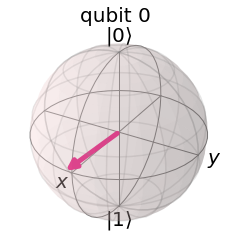

In [3]:
psi = random_statevector(2)
init = Initialize(psi)
init.label = "init"
circuit.append(init, [0])
circuit.h(1)
circuit.cx(1,2)
circuit.barrier()
plot_bloch_multivector(init)

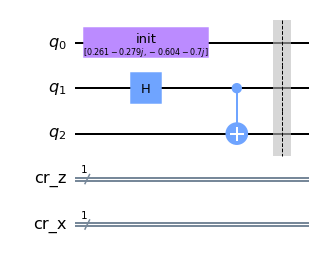

In [4]:
circuit.draw(output="mpl")

Applichiamo adesso una porta CNOT usando il qubit di Alice come controllo e successivamente una porta di Hadamard al qubit di Alice, disegnamo poi il circuito

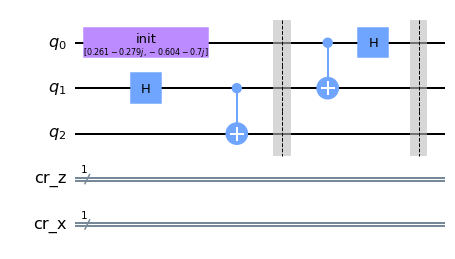

In [5]:
circuit.cx(0, 1)
circuit.h(0)
circuit.barrier()
circuit.draw(output="mpl")

Misuriamo i qubit 0 e 1 e salviamoli nei corrispondenti registri classici

In [6]:
circuit.measure(0,0)
circuit.measure(1,1)
circuit.barrier();

Applichiamo adesso  i gate correttivi seguendo lo schema elencato precedentemente, per fare questo il modo più semplice è usare l'istruzione [`c_if`](https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.c_if.html#qiskit.circuit.Gate.c_if), tuttavia questo non ci permetterà di eseguire il circuito su hardware vero come specificato [in questo](https://github.com/qiskit-community/qiskit-textbook/issues/119#issuecomment-578888019) issue di [qiskit-community/qiskit-textbook/](https://github.com/qiskit-community/qiskit-textbook).  

Disegnamo infine il circuito completo

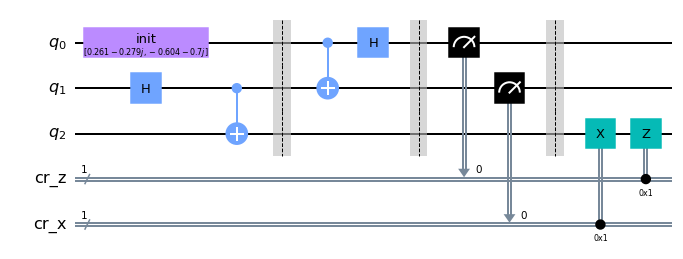

In [7]:
circuit.x(2).c_if(cr_x, 1) 
circuit.z(2).c_if(cr_z, 1)
circuit.draw(output="mpl")

Eseguiamo una simulazione salvando alla fine lo stato del sistema,  dalla sfera di Bloch osserviamo che il qubit 2 e' sempre uguale al qubit 0 generato da Alice precedentemente.

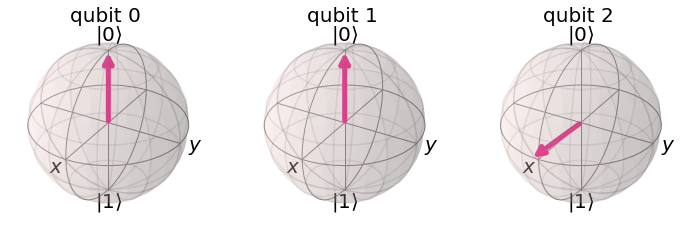

In [8]:
backend = Aer.get_backend('qasm_simulator')
circuit.save_statevector()
out_statevector = execute(circuit, backend).result().get_statevector()
plot_bloch_multivector(out_statevector)

Questo significa che siamo riusciti nel nostro intento di trasferire informazione. Naturalmente il qubit 0 è collassato in uno stato in seguito alla misura di Alice. Possiamo quindi dire che per avere informazione nel qubit 2 abbiamo dovuto distruggere lo stato del qubit 0.

Facciamo adesso delle misure fissando lo stato di partenza  $|\psi \rangle= \alpha^2 |0 \rangle + \beta^2 |1\rangle$ con:
 +  $\alpha^2 =0.9$ e $\beta^2=0.1$ 
 +  $\alpha^2 =0.7$ e $\beta^2=0.3$


In [9]:
def experimentWithState(state):
    qr = QuantumRegister(3) 
    cr_z = ClassicalRegister(1) 
    cr_x = ClassicalRegister(1)
    res = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr_z, cr_x, res)

    init = Initialize(state)
    init.label = "init"
    circuit.append(init, [0])
    
    circuit.h(1)
    circuit.cx(1, 2)
    
    circuit.cx(0, 1)
    circuit.h(0)
    
    circuit.measure(0,0)
    circuit.measure(1,1)
    
    circuit.x(2).c_if(cr_x, 1) 
    circuit.z(2).c_if(cr_z, 1)
        
    circuit.measure(2,2)

    backend = Aer.get_backend('qasm_simulator')
    circuit.save_statevector()
    counts = execute(circuit, backend, shots=SHOTS).result().get_counts()
    return counts

In [10]:
def calcProbabilities(counts):
    probabilities = [0,0]
    for key, val in counts.items():
        if key.startswith('1'):
            probabilities[1] += val
        else:
            probabilities[0] += val
    probabilities[0] = probabilities[0]/SHOTS
    probabilities[1] = probabilities[1]/SHOTS
    return probabilities

[0.89794921875, 0.10205078125]


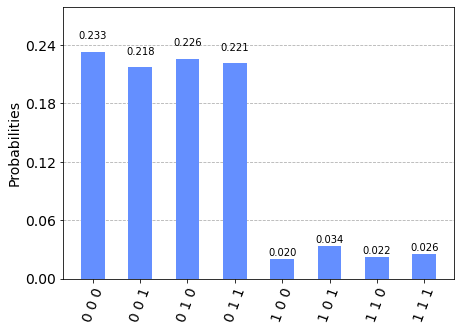

In [11]:
counts = experimentWithState([sqrt(0.9),sqrt(0.1)])
print(calcProbabilities(counts))
plot_histogram(counts)

[0.70556640625, 0.29443359375]


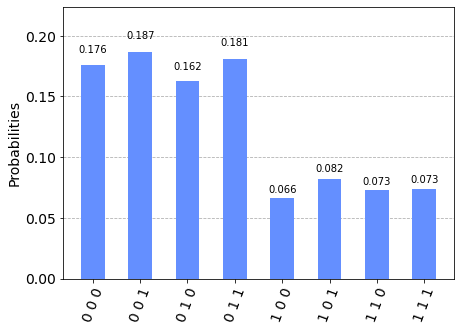

In [12]:
counts = experimentWithState([sqrt(0.7),sqrt(0.3)])
print(calcProbabilities(counts))
plot_histogram(counts)

Ricordando di leggere i qubit considerando $000$ come abbreviazione della forma estesa $|0\rangle_2|0\rangle_1|0\rangle_0$ osserviamo che i valori ottenuti hanno probabilità molto simili a quelli che la teoria della misura ci indica per gli stati di partenza.

Abbiamo quindi verificato sperimentalmente quanto visto precedentemente sulla sfera di Bloch.

Alcune osservazioni:

+ Alice non ha bisogno di informazioni sul qubit che vuole trasferire
+ Sfruttando fenomeni squisitamente quantistici possiamo scambiare informazione a grandi distanze
+ Il teletrasporto (o meglio, il trasferimento di informazione) non è istantaneo, Alice deve inviare classicamente informazione a Bob affinche possa decifrare l'informazione, la velocità della luce rimane quindi un limite insuperabile per il trasferimento dell'informazione. Si può dimostrare infatti che se Bob decidesse di effettuare una misura sul suo qubit senza applicare le porte correttive otterrebbe gli stessi risultati che avrebbe ottenuto misurando il proprio qubit senza aspettare che Alice applicasse i gate ai propri qubit. 

Il fatto che sia impossibile copiare informazione quantistica può sembrare molto limitante, tuttavia abbiamo appena mostrato come trasferire informazione, inoltre sappiamo che è possibile sfruttare il _no-cloning_ theorem per rendere impossibili attacchi _man-in-the-midlle_ in scambi di informazione quantistica tra due peer.

Fermilab e partner sono risuciti a [scambiare informazione attraverso il protocollo di computazione quantistica a 44 km](https://news.fnal.gov/2020/12/fermilab-and-partners-achieve-sustained-high-fidelity-quantum-teleportation/)
di distanza.